# Empirical mode decomposition

EMD is a method for decomposing a time series into components with different frequency content, but without leaving the time domain. Like the wavelet transform, the components are themselves polytonic. In contrast to other methods, however, there is no wavelet bank or dictionary &mdash; the components are extracted from the data 'empirically' (depending totally on the data), stepwise from short-period (high frequency) components to long-period (low frequency, trend-like) components.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np

In [2]:
import scipy.signal

dt = 0.004
f0 = 4.0
t1 = 6.0
f1 = 24.0
t = np.arange(0, t1, dt)
chirp = 0.9 * scipy.signal.chirp(t, f0, t1, f1, method='quadratic') + t**2 / 36

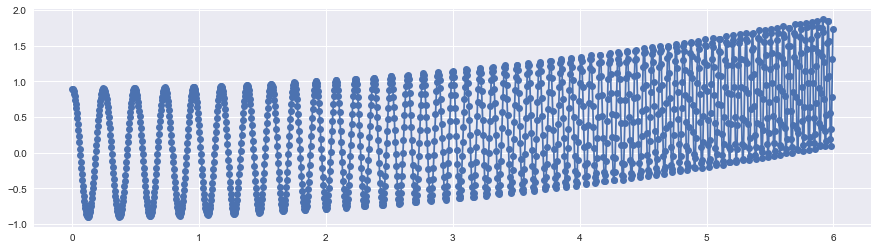

In [3]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, chirp, 'o-')
plt.show()

In [4]:
signal = chirp

In [5]:
fs = 1 / dt

## Naive implementation

Instead of jumping straight into a library, let's try implenting EMD ourselves. I'm using the algorithm described on [this Wikipedia page](https://en.wikipedia.org/wiki/Hilbert%E2%80%93Huang_transform). 

We need to identify the local extrema (local mins and maxes) in the data. Conveniently, `scipy.signal` provides the `argrelextrema()` function:

In [6]:
from scipy.signal import argrelextrema

ma = argrelextrema(signal, np.greater)
mi = argrelextrema(signal, np.less)

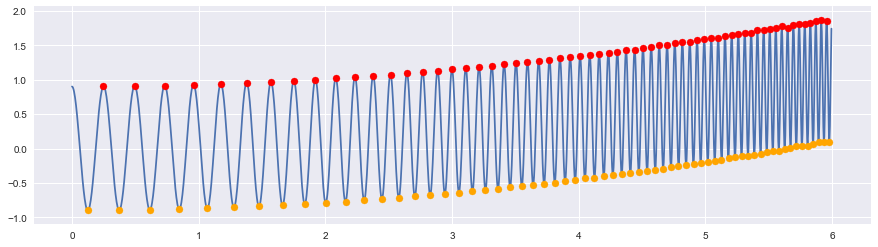

In [7]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, signal)
ax.scatter(t[ma], signal[ma], c='red', zorder=100)
ax.scatter(t[mi], signal[mi], c='orange', zorder=100)
plt.show()

Now we interpolate lines through the minima and the maxima:

In [8]:
from scipy.interpolate import interp1d

func = interp1d(t[ma], signal[ma], kind='cubic', bounds_error=False)
ma_env = func(t)

func = interp1d(t[mi], signal[mi], kind='cubic', bounds_error=False)
mi_env = func(t)

Now we compute the mean of those lines:

In [9]:
h1 = signal - (ma_env + mi_env) / 2

Let's look at the result:

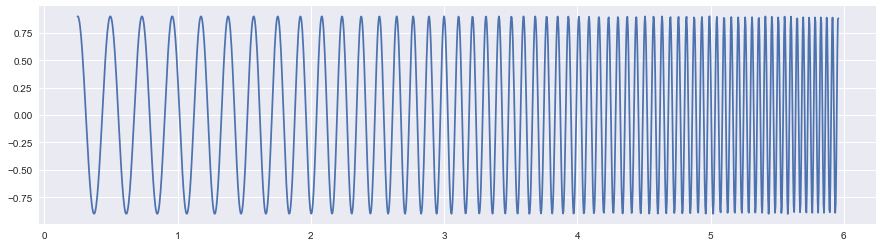

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, h1)
plt.show()

At this point we should 'sift' h1 by repeatedly subjecting `h1` to the same process, but we'll satisfy ourselves with a single iteration and call this the first IMF, or instrinsic mode function.

Let's first turn the previous code blocks into a function:

In [11]:
def extract(t, s):
    ma = argrelextrema(s, np.greater)
    try:
        func = interp1d(t[ma], s[ma], kind='cubic', bounds_error=False)
    except:
        return s
    ma_env = func(t)

    mi = argrelextrema(s, np.less)
    try:
        func = interp1d(t[mi], s[mi], kind='cubic', bounds_error=False)
    except:
        return s
    mi_env = func(t)

    return s - (ma_env + mi_env) / 2

Now we can remove this component from the data, and repeat the process on the residual. (We get some warnings from NaNs, but they're only warnings.)

In [12]:
r1 = signal - h1

/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
/Users/matt/anaconda3/envs/geocomp/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


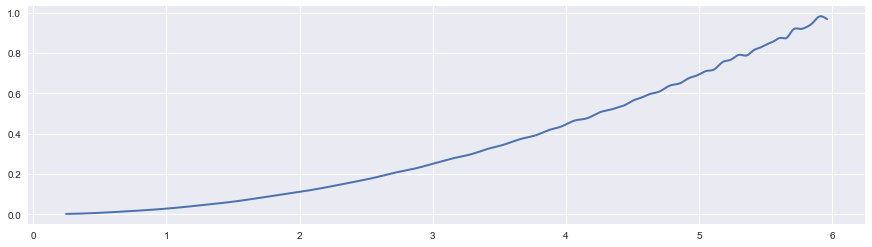

In [13]:
h2 = extract(t, r1)

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, h2, lw=2)
plt.show()

We have reached an essentially monotonic signal, so there are no local minima or maxima, and this is the end of the process. The new residual has zero amplitude:

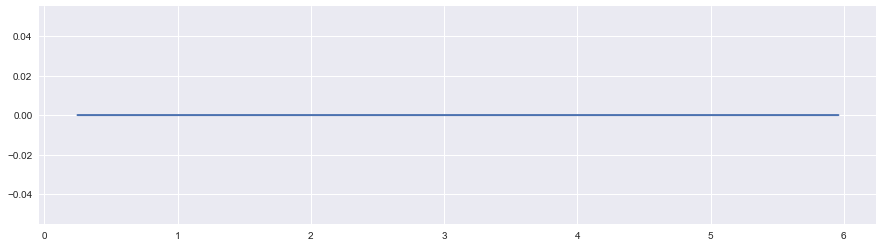

In [14]:
# Use a copy here to avoid changing h2 in place.
r2 = r1 - np.nan_to_num(h2.copy(), 0)

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(t, r2, lw=2)
plt.show()

So we ended up with two IMFs:

In [15]:
def plots(sig, imfs):
    nrows = imfs.shape[0] + 1
    fig, axs = plt.subplots(figsize=(15, 2*nrows), nrows=nrows, sharey=True)
    
    axs[0].plot(t, sig, 'r-')
    axs[0].set_xticklabels([])
    
    for ax, imf in zip(axs[1:], imfs):
        ax.plot(t, imf)
        fig.canvas.draw()  # To make the ticks available
        labels = [l.get_text() for l in ax.get_xticklabels()]
        ax.set_xticklabels([])
    ax.set_xticklabels(labels)
    
    plt.show()
    
    return

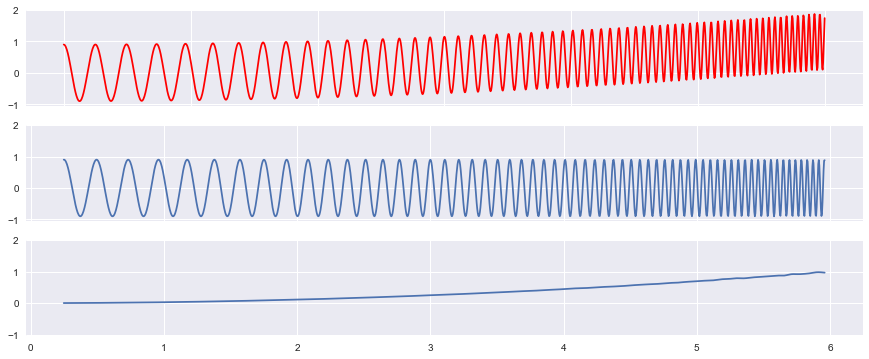

In [16]:
plots(signal, np.array([h1, h2]))

## PyEMD by David Laszuk

It turns out we don't need to implement our own EMD, because David Laszuk has written a really nice one. This saves us the bother of figuring out the sifting process I mentioned, as well as dealing with various edge cases, and general optimization. (Not to mention documentation, testing, etc, etc.)

You will need to install it: [PyEMD](https://github.com/laszukdawid/PyEMD) is a small Python library by [David Laszuk](https://laszukdawid.com/about/).

In [17]:
from PyEMD import EMD

_ = np.random.random(100)
emd = EMD()

In [18]:
IMFs = emd(signal)

In [19]:
IMFs

array([[  8.98607084e-01,   8.94111087e-01,   8.80572166e-01, ...,
         -1.90058909e-01,   3.43651436e-01,   7.64866779e-01],
       [ -7.50015865e-04,  -7.53458237e-04,  -7.56829557e-04, ...,
          3.01193492e-03,   2.86136795e-03,   2.48449902e-03],
       [  2.14293220e-03,   2.09872405e-03,   2.05588101e-03, ...,
          9.72838417e-01,   9.72719357e-01,   9.72666175e-01]])

In [20]:
IMFs.shape

(3, 1500)

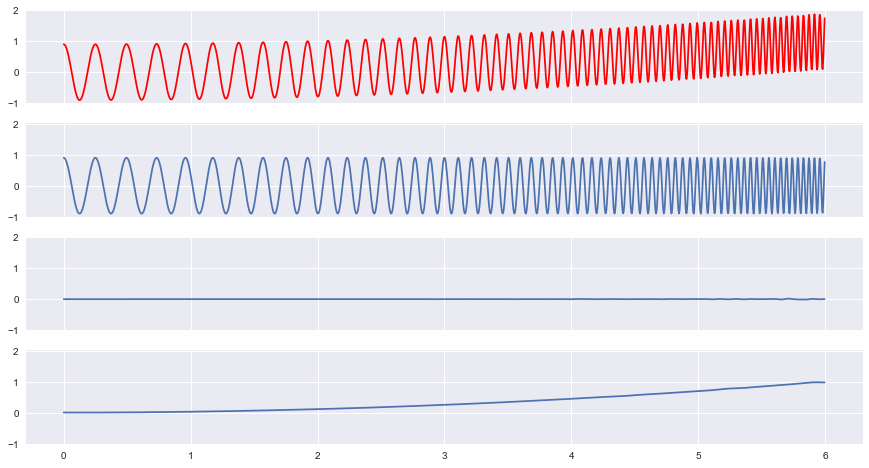

In [22]:
plots(sig=signal, imfs=IMFs)

In [23]:
from PyEMD import EEMD

_ = np.random.random(100)
eemd = EEMD()
eIMFs = eemd(signal)

In [24]:
eIMFs.shape

(8, 1500)

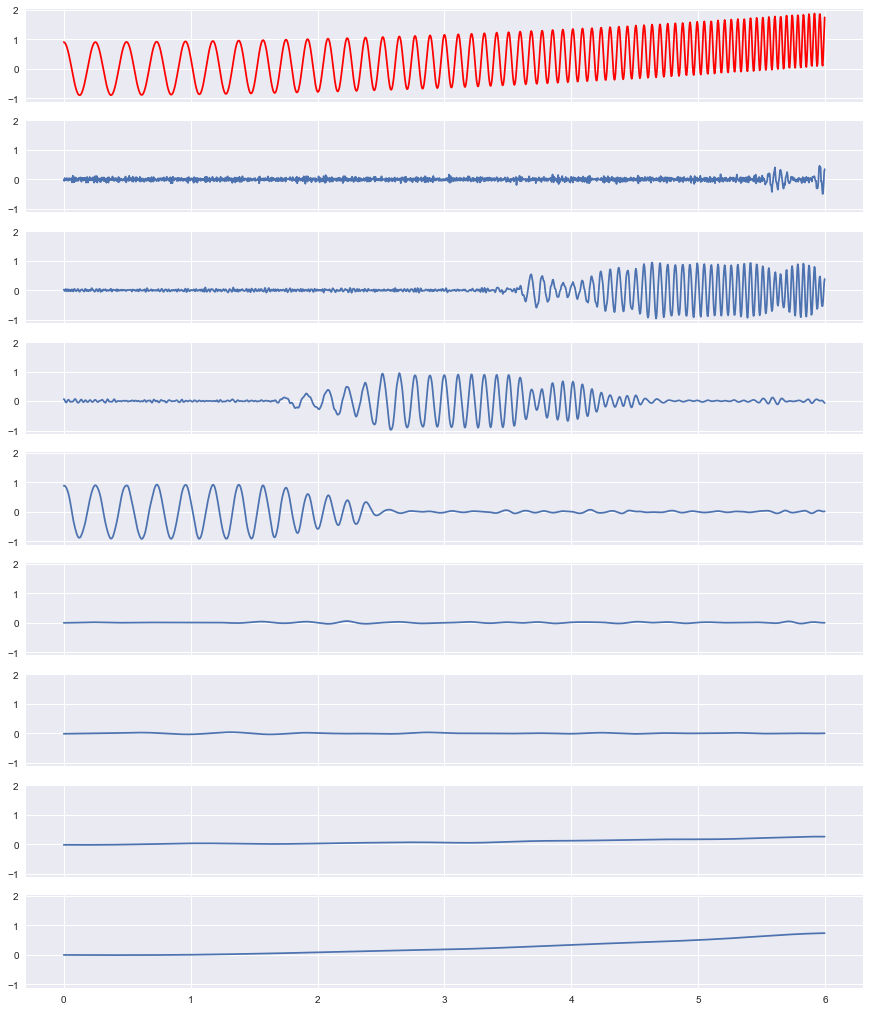

In [25]:
plots(signal, eIMFs)

I don't like this result as much as the regular EMD.

In [26]:
from PyEMD import CEEMDAN

_ = np.random.random(100)
ceemd = CEEMDAN()
ceIMFs = ceemd(signal)

In [27]:
ceIMFs.shape

(8, 1500)

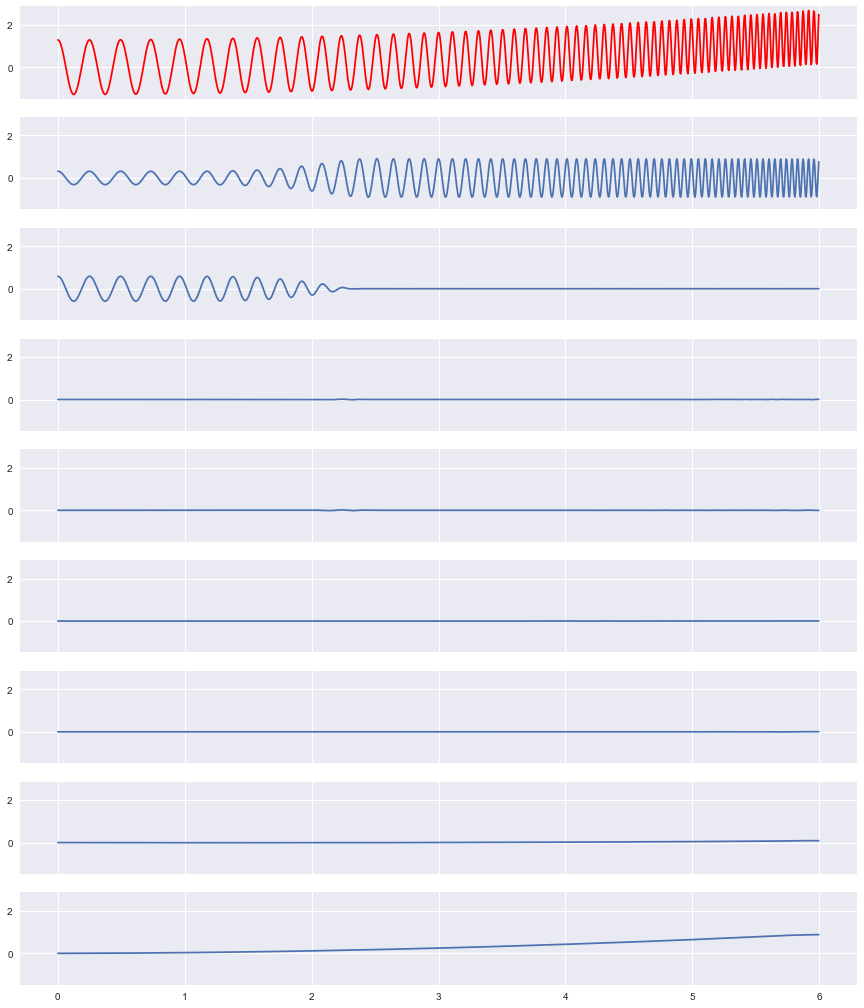

In [28]:
plots(signal, ceIMFs)

Again, there are too many components here.

## Instantaneous frequency

Following Han & van der Baan (2013), GEOPHYSICS 78 (2). https://doi.org/10.1190/GEO2012-0199.1

In [29]:
def inst_freq(x, dt):

    H = scipy.signal.hilbert(x)
    y = np.imag(H)
    
    dx = scipy.signal.savgol_filter(x, delta=dt, window_length=3, polyorder=2, deriv=1)
    dy = scipy.signal.savgol_filter(y, delta=dt, window_length=3, polyorder=2, deriv=1)
    
    f = (x*dy - dx*y) / (x**2 + y**2)
    
    return f / (2 * np.pi)

In [30]:
def inst_amp(x):

    H = scipy.signal.hilbert(x)
    y = np.imag(H)
    
    R = np.sqrt(x**2 + y**2)

    return R

In [31]:
f = inst_freq(ceIMFs, dt=dt)
R = inst_amp(ceIMFs)

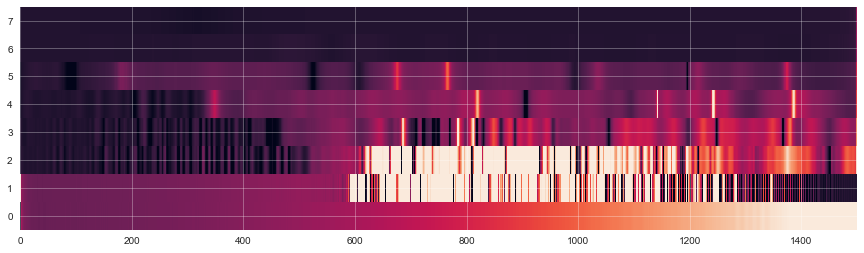

In [32]:
plt.figure(figsize=(15, 5))
plt.imshow(f, aspect=50, vmin=-2, vmax=20, origin='lower')
plt.grid(alpha=0.3)

In [33]:
f[f<1] = 0

In [34]:
from scipy.interpolate import Rbf

freq_new = np.arange(50)

spectrum = []
for f_, R_ in zip(f.T, R.T):
    func = Rbf(f_, R_, function='gaussian', epsilon=2, smooth=1e-3)
    spectrum.append(func(freq_new))
spectrum = np.array(spectrum)

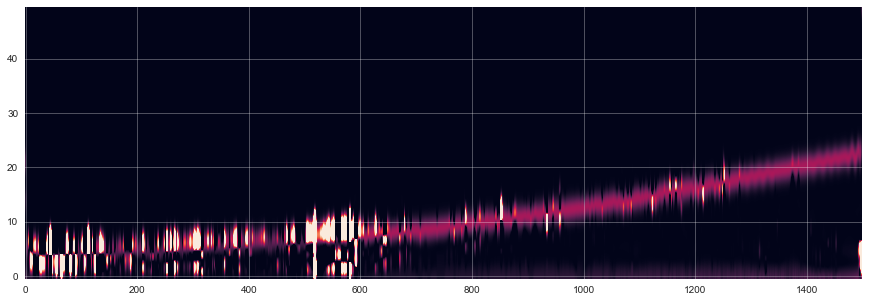

In [35]:
plt.figure(figsize=(15, 5))
plt.imshow(spectrum.T, aspect='auto', origin='lower', vmin=0, vmax=2, interpolation='bicubic')
plt.grid(alpha=0.3)

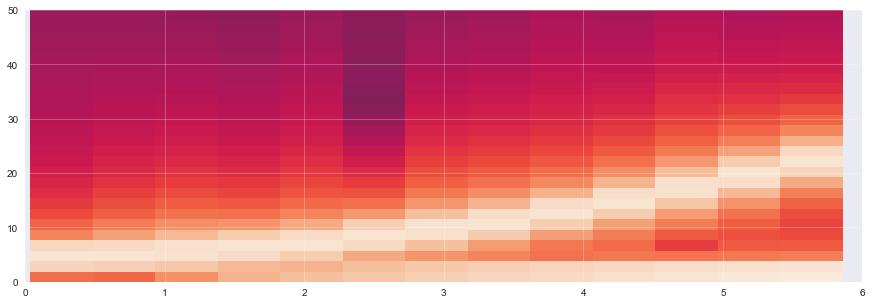

In [36]:
plt.figure(figsize=(15, 5))
plt.specgram(signal, NFFT=128, Fs=1/dt, noverlap=16)
plt.ylim((0, 50))
plt.xlim((0, 6))
plt.grid(alpha=0.25)
plt.show()